In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

# interp1, 2 are the parameter values, starting from 0
interp1 = 4 # in reality, param no. interp1+1
interp2 = 5 # in reality, param no. interp2+1


n_epochs = 10000
n_epochs_latent=50
batch_size = 1
LR = 2e-5
Lv1_latent_dim = 64
Lv2_latent_dim = 32
epoch_1 = 300

alpha = 0

In [10]:
f = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d_batchnorm' %(i+1)
    temp = np.loadtxt(filename3)
    f[i,:,:] = np.loadtxt(filename3)

In [11]:
f.shape

(10, 800, 128)

## Scale latent codes from Lv 1.

In [12]:
maximum = np.amax(f)
minimum = np.amin(f)
mean = np.mean(f)
AT = maximum-minimum

f = f-mean
f = f/AT

In [13]:
print(np.max(f))
print(np.min(f))

0.5200840016889556
-0.47991599831104437


# Level 2, TVAE (Temporal VAE)

In [14]:
# Lv2_input = (num_param, num_time, Lv1 latent vector dim)

Lv2_input = f
Lv2_input.shape

(10, 800, 128)

In [15]:
#validate

Lv2_input_shape_decoder = Lv2_input.shape[1]

In [16]:
Lv2_input_shape = Lv2_input.shape[1:]

In [17]:
print(Lv2_input.shape)
print(Lv2_input_shape)

(10, 800, 128)
(800, 128)


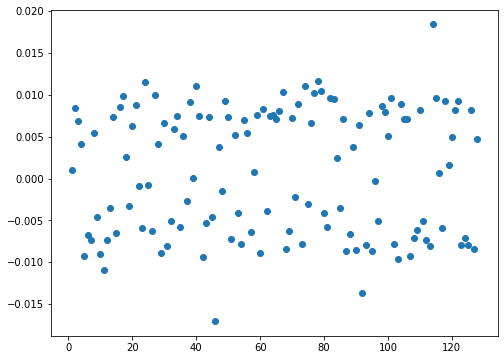

In [18]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)
plt.scatter(x_axis1, Lv2_input[0,0,:])

# Encoder

In [19]:
def encoder():
    x_input=layers.Input(shape=Lv2_input_shape)
    x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    x=layers.Dense(Lv2_latent_dim)(x)
    
    #mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    #eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [x], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 128)]        0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 804, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 804, 64)           41024     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 804, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 804, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 804, 128)          41088     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 804, 128)          0   

# Decoder

In [20]:
print(Lv2_latent_dim)
print(Lv2_input_shape_decoder)

64
800


In [21]:
def decoder():
    z_input=layers.Input(shape=(Lv2_latent_dim))
    
    z=layers.Dense(Lv2_input_shape_decoder*Lv2_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv2_input_shape_decoder,Lv2_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)        
    
    z=layers.Dense(Lv1_latent_dim)(z)
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [z], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 51200)             3328000   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 51200)             0         
_________________________________________________________________
reshape (Reshape)            (None, 800, 64)           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 800, 256)          65792     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 800, 256)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 800, 256)          0   

# loss computation

In [22]:
def compute_loss(real_img, fake_img):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(real_img-fake_img)))
    
    loss = reconstruction_error
    
    return loss

# VAE

In [23]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(real_img, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            fake_img = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(real_img, fake_img)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [24]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv2_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv2_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained_Lv2/decoder_%d_batchnorm.h5' % (epoch+1)
                filename2 = 'test_constrained_Lv2/encoder_%d_batchnorm.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [25]:
Lv2_input.shape
print(type(Lv2_input))

<class 'numpy.ndarray'>


# Warm up

In [26]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.999)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv2_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv2_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=losses.MeanSquaredError())

start = time.time()
vae.fit(Lv2_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/10000
10/10 [==============================] - 6s 10ms/step - loss: 2.7959e-04
Epoch 2/10000
10/10 [==============================] - 0s 9ms/step - loss: 3.2733e-04
Epoch 3/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.8529e-04
Epoch 4/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.9986e-04
Epoch 5/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.8419e-04
Epoch 6/10000
10/10 [==============================] - 0s 9ms/step - loss: 3.2502e-04
Epoch 7/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.8324e-04
Epoch 8/10000
10/10 [==============================] - 0s 9ms/step - loss: 3.0948e-04
Epoch 9/10000
10/10 [==============================] - 0s 7ms/step - loss: 2.9739e-04
Epoch 10/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.7494e-04
Epoch 11/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.7747e-04
Epoch 12/10000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 1.7915e-04
Epoch 96/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.7301e-04
Epoch 97/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.6726e-04
Epoch 98/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.6762e-04
Epoch 99/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.6442e-04
Epoch 100/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.8914e-04
Epoch 101/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.7915e-04
Epoch 102/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.6171e-04
Epoch 103/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.6166e-04
Epoch 104/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.6116e-04
Epoch 105/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.9525e-04
Epoch 106/10000
10/10 [============================

10/10 [==============================] - 0s 9ms/step - loss: 1.2238e-04
Epoch 189/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2162e-04
Epoch 190/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.2288e-04
Epoch 191/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.3696e-04
Epoch 192/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.2072e-04
Epoch 193/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.2369e-04
Epoch 194/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.1970e-04
Epoch 195/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.1980e-04
Epoch 196/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.2026e-04
Epoch 197/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2224e-04
Epoch 198/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.2941e-04
Epoch 199/10000
10/10 [========================

10/10 [==============================] - 0s 8ms/step - loss: 9.7456e-05
Epoch 282/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.0901e-04
Epoch 283/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.8155e-05
Epoch 284/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.4323e-05
Epoch 285/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.0764e-04
Epoch 286/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.3989e-05
Epoch 287/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.4919e-05
Epoch 288/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.0290e-04
Epoch 289/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.8352e-05
Epoch 290/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0117e-04
Epoch 291/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.3308e-05
Epoch 292/10000
10/10 [=====================

10/10 [==============================] - 0s 10ms/step - loss: 7.7387e-05
Epoch 375/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.3215e-05
Epoch 376/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5397e-05
Epoch 377/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6597e-05
Epoch 378/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5645e-05
Epoch 379/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4659e-05
Epoch 380/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.0953e-05
Epoch 381/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4800e-05
Epoch 382/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4734e-05
Epoch 383/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4508e-05
Epoch 384/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.4009e-05
Epoch 385/10000
10/10 [====================

Epoch 467/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.8170e-05
Epoch 468/10000
10/10 [==============================] - 0s 8ms/step - loss: 6.1966e-05
Epoch 469/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0891e-05
Epoch 470/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4912e-05
Epoch 471/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.1155e-05
Epoch 472/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.1118e-05
Epoch 473/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.2931e-05
Epoch 474/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.4966e-05
Epoch 475/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.1300e-05
Epoch 476/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.0500e-05
Epoch 477/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.1339e-05
Epoch 478/10000
10/10 [======

10/10 [==============================] - 0s 7ms/step - loss: 4.2885e-05
Epoch 653/10000
10/10 [==============================] - 0s 7ms/step - loss: 4.8790e-05
Epoch 654/10000
10/10 [==============================] - 0s 7ms/step - loss: 4.3917e-05
Epoch 655/10000
10/10 [==============================] - 0s 7ms/step - loss: 4.2103e-05
Epoch 656/10000
10/10 [==============================] - 0s 7ms/step - loss: 4.4667e-05
Epoch 657/10000
10/10 [==============================] - 0s 7ms/step - loss: 4.6280e-05
Epoch 658/10000
10/10 [==============================] - 0s 7ms/step - loss: 4.6068e-05
Epoch 659/10000
10/10 [==============================] - 0s 7ms/step - loss: 4.1567e-05
Epoch 660/10000
10/10 [==============================] - 0s 8ms/step - loss: 4.4107e-05
Epoch 661/10000
10/10 [==============================] - 0s 9ms/step - loss: 4.1685e-05
Epoch 662/10000
10/10 [==============================] - 0s 7ms/step - loss: 4.1409e-05
Epoch 663/10000
10/10 [=========================

10/10 [==============================] - 0s 7ms/step - loss: 3.0352e-05
Epoch 839/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.9991e-05
Epoch 840/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2154e-05
Epoch 841/10000
10/10 [==============================] - 0s 9ms/step - loss: 3.4478e-05
Epoch 842/10000
10/10 [==============================] - 0s 9ms/step - loss: 3.2067e-05
Epoch 843/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2564e-05
Epoch 844/10000
10/10 [==============================] - 0s 8ms/step - loss: 3.0061e-05
Epoch 845/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2281e-05
Epoch 846/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.9867e-05
Epoch 847/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.9595e-05
Epoch 848/10000
10/10 [==============================] - 0s 8ms/step - loss: 3.3579e-05
Epoch 849/10000
10/10 [======================

10/10 [==============================] - 0s 9ms/step - loss: 2.7044e-05
Epoch 932/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.5803e-05
Epoch 933/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.8393e-05
Epoch 934/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.5638e-05
Epoch 935/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.5815e-05
Epoch 936/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.6862e-05
Epoch 937/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.7965e-05
Epoch 938/10000
10/10 [==============================] - 0s 7ms/step - loss: 2.5725e-05
Epoch 939/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.6127e-05
Epoch 940/10000
10/10 [==============================] - 0s 7ms/step - loss: 2.6095e-05
Epoch 941/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.9951e-05
Epoch 942/10000
10/10 [=======================

10/10 [==============================] - 0s 8ms/step - loss: 2.5253e-05
Epoch 1021/10000
10/10 [==============================] - 0s 7ms/step - loss: 2.5474e-05
Epoch 1022/10000
10/10 [==============================] - 0s 7ms/step - loss: 2.4494e-05
Epoch 1023/10000
10/10 [==============================] - 0s 7ms/step - loss: 2.2995e-05
Epoch 1024/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.4396e-05
Epoch 1025/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.2117e-05
Epoch 1026/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.2863e-05
Epoch 1027/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.2615e-05
Epoch 1028/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.2260e-05
Epoch 1029/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.2129e-05
Epoch 1030/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.2137e-05
Epoch 1031/10000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 1.9588e-05
Epoch 1113/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.0112e-05
Epoch 1114/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.0060e-05
Epoch 1115/10000
10/10 [==============================] - 0s 9ms/step - loss: 2.0063e-05
Epoch 1116/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.9642e-05
Epoch 1117/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.1488e-05
Epoch 1118/10000
10/10 [==============================] - 0s 8ms/step - loss: 2.0098e-05
Epoch 1119/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.9641e-05
Epoch 1120/10000
10/10 [==============================] - 0s 7ms/step - loss: 2.0185e-05
Epoch 1121/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.9836e-05
Epoch 1122/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.9385e-05
Epoch 1123/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 1.7645e-05
Epoch 1205/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.9525e-05
Epoch 1206/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.8124e-05
Epoch 1207/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.8446e-05
Epoch 1208/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.7627e-05
Epoch 1209/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.9008e-05
Epoch 1210/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.8924e-05
Epoch 1211/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.7615e-05
Epoch 1212/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.8543e-05
Epoch 1213/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.8030e-05
Epoch 1214/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.8204e-05
Epoch 1215/10000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: 1.9115e-05
Epoch 1297/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.6251e-05
Epoch 1298/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.5794e-05
Epoch 1299/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.6273e-05
Epoch 1300/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.7352e-05
Epoch 1301/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.5772e-05
Epoch 1302/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.8946e-05
Epoch 1303/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.8456e-05
Epoch 1304/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.6176e-05
Epoch 1305/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.7545e-05
Epoch 1306/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.8335e-05
Epoch 1307/10000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: 1.4790e-05
Epoch 1389/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.5558e-05
Epoch 1390/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.4606e-05
Epoch 1391/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.4868e-05
Epoch 1392/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.4803e-05
Epoch 1393/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.4496e-05
Epoch 1394/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.4605e-05
Epoch 1395/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.6084e-05
Epoch 1396/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.4452e-05
Epoch 1397/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4580e-05
Epoch 1398/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4171e-05
Epoch 1399/10000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: 1.3952e-05
Epoch 1481/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.3474e-05
Epoch 1482/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.4384e-05
Epoch 1483/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.3516e-05
Epoch 1484/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.4490e-05
Epoch 1485/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.3653e-05
Epoch 1486/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.3370e-05
Epoch 1487/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.5567e-05
Epoch 1488/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.3676e-05
Epoch 1489/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.3878e-05
Epoch 1490/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.3329e-05
Epoch 1491/10000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: 1.3413e-05
Epoch 1573/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.2861e-05
Epoch 1574/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.4092e-05
Epoch 1575/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.2702e-05
Epoch 1576/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2552e-05
Epoch 1577/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2882e-05
Epoch 1578/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2575e-05
Epoch 1579/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.4001e-05
Epoch 1580/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.3028e-05
Epoch 1581/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.2713e-05
Epoch 1582/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2779e-05
Epoch 1583/10000
10/10 [=============

10/10 [==============================] - 0s 7ms/step - loss: 1.2754e-05
Epoch 1665/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.3649e-05
Epoch 1666/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.1810e-05
Epoch 1667/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.3833e-05
Epoch 1668/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.3488e-05
Epoch 1669/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2203e-05
Epoch 1670/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1660e-05
Epoch 1671/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2031e-05
Epoch 1672/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.2623e-05
Epoch 1673/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2164e-05
Epoch 1674/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.1756e-05
Epoch 1675/10000
10/10 [===========

10/10 [==============================] - 0s 10ms/step - loss: 1.1287e-05
Epoch 1757/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.1565e-05
Epoch 1758/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.1261e-05
Epoch 1759/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.3289e-05
Epoch 1760/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.1250e-05
Epoch 1761/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2725e-05
Epoch 1762/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1426e-05
Epoch 1763/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.3083e-05
Epoch 1764/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.1340e-05
Epoch 1765/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.1548e-05
Epoch 1766/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.1392e-05
Epoch 1767/10000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: 1.0866e-05
Epoch 1849/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.1433e-05
Epoch 1850/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0752e-05
Epoch 1851/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.1798e-05
Epoch 1852/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.1506e-05
Epoch 1853/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0713e-05
Epoch 1854/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.2016e-05
Epoch 1855/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0846e-05
Epoch 1856/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.0591e-05
Epoch 1857/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.1048e-05
Epoch 1858/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0673e-05
Epoch 1859/10000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 1.0748e-05
Epoch 1941/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.2205e-05
Epoch 1942/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0923e-05
Epoch 1943/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0332e-05
Epoch 1944/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.0463e-05
Epoch 1945/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.1029e-05
Epoch 1946/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.0365e-05
Epoch 1947/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0335e-05
Epoch 1948/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0946e-05
Epoch 1949/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0703e-05
Epoch 1950/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0490e-05
Epoch 1951/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 9.7400e-06
Epoch 2121/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.1307e-05
Epoch 2122/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.8655e-06
Epoch 2123/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0383e-05
Epoch 2124/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0041e-05
Epoch 2125/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.9115e-06
Epoch 2126/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.8672e-06
Epoch 2127/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0336e-05
Epoch 2128/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.8788e-06
Epoch 2129/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0708e-05
Epoch 2130/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0944e-05
Epoch 2131/10000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: 9.8361e-06
Epoch 2213/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.6064e-06
Epoch 2214/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.7563e-06
Epoch 2215/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.8268e-06
Epoch 2216/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0344e-05
Epoch 2217/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.0312e-05
Epoch 2218/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.0710e-05
Epoch 2219/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.4686e-06
Epoch 2220/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.5429e-06
Epoch 2221/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.5431e-06
Epoch 2222/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.9011e-06
Epoch 2223/10000
10/10 [===========

10/10 [==============================] - 0s 9ms/step - loss: 9.3324e-06
Epoch 2305/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.3754e-06
Epoch 2306/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.5948e-06
Epoch 2307/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.2722e-06
Epoch 2308/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.6676e-06
Epoch 2309/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.4221e-06
Epoch 2310/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0028e-05
Epoch 2311/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.3648e-06
Epoch 2312/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.3816e-06
Epoch 2313/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.3839e-06
Epoch 2314/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.3895e-06
Epoch 2315/10000
10/10 [==============

10/10 [==============================] - 0s 7ms/step - loss: 9.3417e-06
Epoch 2397/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.3217e-06
Epoch 2398/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.9537e-06
Epoch 2399/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.3559e-06
Epoch 2400/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0201e-05
Epoch 2401/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0343e-05
Epoch 2402/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.4931e-06
Epoch 2403/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.4222e-06
Epoch 2404/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.5530e-06
Epoch 2405/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.2570e-06
Epoch 2406/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.2584e-06
Epoch 2407/10000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: 9.1308e-06
Epoch 2581/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.0267e-05
Epoch 2582/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.5437e-06
Epoch 2583/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.9473e-06
Epoch 2584/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.2374e-06
Epoch 2585/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.7458e-06
Epoch 2586/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.1219e-06
Epoch 2587/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.4055e-06
Epoch 2588/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.6603e-06
Epoch 2589/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.9824e-06
Epoch 2590/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.8930e-06
Epoch 2591/10000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: 8.8171e-06
Epoch 2765/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.7886e-06
Epoch 2766/10000
10/10 [==============================] - 0s 9ms/step - loss: 1.0358e-05
Epoch 2767/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.9618e-06
Epoch 2768/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.1116e-06
Epoch 2769/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.6341e-06
Epoch 2770/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.3468e-06
Epoch 2771/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.9905e-06
Epoch 2772/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.5411e-06
Epoch 2773/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.9604e-06
Epoch 2774/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.6611e-06
Epoch 2775/10000
10/10 [==============

10/10 [==============================] - 0s 7ms/step - loss: 9.0986e-06
Epoch 2949/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.6598e-06
Epoch 2950/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.3360e-06
Epoch 2951/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.4207e-06
Epoch 2952/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.3170e-06
Epoch 2953/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.5574e-06
Epoch 2954/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.3988e-06
Epoch 2955/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.7237e-06
Epoch 2956/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.5073e-06
Epoch 2957/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.1958e-06
Epoch 2958/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.5806e-06
Epoch 2959/10000
10/10 [============

10/10 [==============================] - 0s 7ms/step - loss: 8.8419e-06
Epoch 3129/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.5116e-06
Epoch 3130/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2539e-06
Epoch 3131/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.2962e-06
Epoch 3132/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.3108e-06
Epoch 3133/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.6342e-06
Epoch 3134/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.1544e-06
Epoch 3135/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.2175e-06
Epoch 3136/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.1735e-06
Epoch 3137/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.3305e-06
Epoch 3138/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.3755e-06
Epoch 3139/10000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: 9.3651e-06
Epoch 3221/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1681e-06
Epoch 3222/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2370e-06
Epoch 3223/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.2257e-06
Epoch 3224/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.3843e-06
Epoch 3225/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.4498e-06
Epoch 3226/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.0745e-06
Epoch 3227/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2488e-06
Epoch 3228/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.1315e-06
Epoch 3229/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2778e-06
Epoch 3230/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.5626e-06
Epoch 3231/10000
10/10 [===========

10/10 [==============================] - 0s 9ms/step - loss: 8.3373e-06
Epoch 3313/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.2116e-06
Epoch 3314/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.6383e-06
Epoch 3315/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.0545e-06
Epoch 3316/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2089e-06
Epoch 3317/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.8608e-06
Epoch 3318/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.5406e-06
Epoch 3319/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0519e-06
Epoch 3320/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0903e-06
Epoch 3321/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.3395e-06
Epoch 3322/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.2364e-06
Epoch 3323/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 9.4291e-06
Epoch 3405/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.3104e-06
Epoch 3406/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1975e-06
Epoch 3407/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.1657e-06
Epoch 3408/10000
10/10 [==============================] - 0s 9ms/step - loss: 9.1765e-06
Epoch 3409/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.5822e-06
Epoch 3410/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.2579e-06
Epoch 3411/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.3149e-06
Epoch 3412/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2869e-06
Epoch 3413/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9613e-06
Epoch 3414/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.6381e-06
Epoch 3415/10000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 8.0872e-06
Epoch 3497/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.8208e-06
Epoch 3498/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0115e-06
Epoch 3499/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.3195e-06
Epoch 3500/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2088e-06
Epoch 3501/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.5711e-06
Epoch 3502/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.9604e-06
Epoch 3503/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2151e-06
Epoch 3504/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.1082e-06
Epoch 3505/10000
10/10 [==============================] - 0s 7ms/step - loss: 9.1320e-06
Epoch 3506/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2830e-06
Epoch 3507/10000
10/10 [=============

10/10 [==============================] - 0s 10ms/step - loss: 7.9499e-06
Epoch 3589/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8837e-06
Epoch 3590/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.8127e-06
Epoch 3591/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.8968e-06
Epoch 3592/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6786e-06
Epoch 3593/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.4011e-06
Epoch 3594/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0686e-06
Epoch 3595/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9666e-06
Epoch 3596/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0627e-06
Epoch 3597/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1366e-06
Epoch 3598/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7502e-06
Epoch 3599/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 7.9189e-06
Epoch 3681/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8558e-06
Epoch 3682/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9429e-06
Epoch 3683/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.5283e-06
Epoch 3684/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9134e-06
Epoch 3685/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9871e-06
Epoch 3686/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.0124e-06
Epoch 3687/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8387e-06
Epoch 3688/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8473e-06
Epoch 3689/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8104e-06
Epoch 3690/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9605e-06
Epoch 3691/10000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 8.5910e-06
Epoch 3773/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9700e-06
Epoch 3774/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.9405e-06
Epoch 3775/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.2221e-06
Epoch 3776/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.1483e-06
Epoch 3777/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1489e-06
Epoch 3778/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2426e-06
Epoch 3779/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6549e-06
Epoch 3780/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.7349e-06
Epoch 3781/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9831e-06
Epoch 3782/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1100e-06
Epoch 3783/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 7.9988e-06
Epoch 3865/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8991e-06
Epoch 3866/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.8366e-06
Epoch 3867/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.0442e-06
Epoch 3868/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.0415e-06
Epoch 3869/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8105e-06
Epoch 3870/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.9464e-06
Epoch 3871/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2563e-06
Epoch 3872/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8547e-06
Epoch 3873/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.0524e-06
Epoch 3874/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.0327e-06
Epoch 3875/10000
10/10 [========

10/10 [==============================] - 0s 8ms/step - loss: 8.0710e-06
Epoch 3957/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1407e-06
Epoch 3958/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7618e-06
Epoch 3959/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7053e-06
Epoch 3960/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.5493e-06
Epoch 3961/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5443e-06
Epoch 3962/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9037e-06
Epoch 3963/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.1109e-06
Epoch 3964/10000
10/10 [==============================] - 0s 8ms/step - loss: 9.2216e-06
Epoch 3965/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1481e-06
Epoch 3966/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.5467e-06
Epoch 3967/10000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 7.8042e-06
Epoch 4137/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.8072e-06
Epoch 4138/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.8347e-06
Epoch 4139/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9819e-06
Epoch 4140/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.6748e-06
Epoch 4141/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.4616e-06
Epoch 4142/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7307e-06
Epoch 4143/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.6949e-06
Epoch 4144/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.3656e-06
Epoch 4145/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7575e-06
Epoch 4146/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8029e-06
Epoch 4147/10000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: 8.3619e-06
Epoch 4229/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7673e-06
Epoch 4230/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.8925e-06
Epoch 4231/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7957e-06
Epoch 4232/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.5965e-06
Epoch 4233/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0795e-06
Epoch 4234/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7595e-06
Epoch 4235/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9008e-06
Epoch 4236/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.1057e-06
Epoch 4237/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.8076e-06
Epoch 4238/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.8467e-06
Epoch 4239/10000
10/10 [============

Epoch 4320/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.7084e-06
Epoch 4321/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5073e-06
Epoch 4322/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6267e-06
Epoch 4323/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.9092e-06
Epoch 4324/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.4127e-06
Epoch 4325/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.6748e-06
Epoch 4326/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.7480e-06
Epoch 4327/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5097e-06
Epoch 4328/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7013e-06
Epoch 4329/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1738e-06
Epoch 4330/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7607e-06
Epoch 4331/10000
1

Epoch 4503/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.8527e-06
Epoch 4504/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5931e-06
Epoch 4505/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7156e-06
Epoch 4506/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.9699e-06
Epoch 4507/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.3754e-06
Epoch 4508/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2138e-06
Epoch 4509/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6449e-06
Epoch 4510/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.3998e-06
Epoch 4511/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1620e-06
Epoch 4512/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2089e-06
Epoch 4513/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.6986e-06
Epoch 4514/10000
10/1

Epoch 4595/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5655e-06
Epoch 4596/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.6739e-06
Epoch 4597/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5762e-06
Epoch 4598/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9142e-06
Epoch 4599/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.2080e-06
Epoch 4600/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0125e-06
Epoch 4601/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.8278e-06
Epoch 4602/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6583e-06
Epoch 4603/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.6187e-06
Epoch 4604/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5846e-06
Epoch 4605/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2513e-06
Epoch 4606/10000
10/

10/10 [==============================] - 0s 9ms/step - loss: 8.8010e-06
Epoch 4779/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.5707e-06
Epoch 4780/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5300e-06
Epoch 4781/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6245e-06
Epoch 4782/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0778e-06
Epoch 4783/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6077e-06
Epoch 4784/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5174e-06
Epoch 4785/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.4392e-06
Epoch 4786/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5519e-06
Epoch 4787/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.5154e-06
Epoch 4788/10000
10/10 [==============================] - 0s 13ms/step - loss: 7.9212e-06
Epoch 4789/10000
10/10 [===========

Epoch 4870/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5290e-06
Epoch 4871/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.8174e-06
Epoch 4872/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.7941e-06
Epoch 4873/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4259e-06
Epoch 4874/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7572e-06
Epoch 4875/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2479e-06
Epoch 4876/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.5042e-06
Epoch 4877/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6387e-06
Epoch 4878/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3605e-06
Epoch 4879/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.2829e-06
Epoch 4880/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7155e-06
Epoch 4881/10000
10

10/10 [==============================] - 0s 10ms/step - loss: 7.4412e-06
Epoch 5050/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.9260e-06
Epoch 5051/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.8100e-06
Epoch 5052/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8574e-06
Epoch 5053/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7514e-06
Epoch 5054/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2164e-06
Epoch 5055/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.4947e-06
Epoch 5056/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.6317e-06
Epoch 5057/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2912e-06
Epoch 5058/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5508e-06
Epoch 5059/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2370e-06
Epoch 5060/10000
10/10 [===========

Epoch 5141/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4904e-06
Epoch 5142/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4784e-06
Epoch 5143/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.5022e-06
Epoch 5144/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3840e-06
Epoch 5145/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5610e-06
Epoch 5146/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6241e-06
Epoch 5147/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2039e-06
Epoch 5148/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0615e-06
Epoch 5149/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3185e-06
Epoch 5150/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4811e-06
Epoch 5151/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1449e-06
Epoch 5152/10000
10/1

Epoch 5233/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6856e-06
Epoch 5234/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5271e-06
Epoch 5235/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8092e-06
Epoch 5236/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6345e-06
Epoch 5237/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1458e-06
Epoch 5238/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5235e-06
Epoch 5239/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.6792e-06
Epoch 5240/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.9973e-06
Epoch 5241/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5940e-06
Epoch 5242/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4616e-06
Epoch 5243/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9064e-06
Epoch 5244/10000
10/

10/10 [==============================] - 0s 8ms/step - loss: 7.5230e-06
Epoch 5417/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9391e-06
Epoch 5418/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8210e-06
Epoch 5419/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3363e-06
Epoch 5420/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6153e-06
Epoch 5421/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4019e-06
Epoch 5422/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5450e-06
Epoch 5423/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0915e-06
Epoch 5424/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5363e-06
Epoch 5425/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6836e-06
Epoch 5426/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5901e-06
Epoch 5427/10000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: 8.8776e-06
Epoch 5509/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4624e-06
Epoch 5510/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7566e-06
Epoch 5511/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3693e-06
Epoch 5512/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3747e-06
Epoch 5513/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.2428e-06
Epoch 5514/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5525e-06
Epoch 5515/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6074e-06
Epoch 5516/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6050e-06
Epoch 5517/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1158e-06
Epoch 5518/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1513e-06
Epoch 5519/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 7.5975e-06
Epoch 5601/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.5165e-06
Epoch 5602/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1170e-06
Epoch 5603/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.3427e-06
Epoch 5604/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5419e-06
Epoch 5605/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.4796e-06
Epoch 5606/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.8562e-06
Epoch 5607/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8079e-06
Epoch 5608/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3761e-06
Epoch 5609/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.3525e-06
Epoch 5610/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4449e-06
Epoch 5611/10000
10/10 [==============

10/10 [==============================] - 0s 7ms/step - loss: 7.4021e-06
Epoch 5693/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0818e-06
Epoch 5694/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5569e-06
Epoch 5695/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4051e-06
Epoch 5696/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5617e-06
Epoch 5697/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3615e-06
Epoch 5698/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2010e-06
Epoch 5699/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.3018e-06
Epoch 5700/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2594e-06
Epoch 5701/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4532e-06
Epoch 5702/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7894e-06
Epoch 5703/10000
10/10 [==============

10/10 [==============================] - 0s 7ms/step - loss: 7.8563e-06
Epoch 5785/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.7495e-06
Epoch 5786/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2793e-06
Epoch 5787/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.1053e-06
Epoch 5788/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.3598e-06
Epoch 5789/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.5371e-06
Epoch 5790/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.5761e-06
Epoch 5791/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3876e-06
Epoch 5792/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.8322e-06
Epoch 5793/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.4138e-06
Epoch 5794/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4735e-06
Epoch 5795/10000
10/10 [==============

10/10 [==============================] - 0s 7ms/step - loss: 8.1250e-06
Epoch 5877/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3559e-06
Epoch 5878/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4098e-06
Epoch 5879/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3298e-06
Epoch 5880/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2395e-06
Epoch 5881/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.2344e-06
Epoch 5882/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.5619e-06
Epoch 5883/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3810e-06
Epoch 5884/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4680e-06
Epoch 5885/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4126e-06
Epoch 5886/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8373e-06
Epoch 5887/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 7.5913e-06
Epoch 5969/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4338e-06
Epoch 5970/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.9404e-06
Epoch 5971/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9720e-06
Epoch 5972/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3662e-06
Epoch 5973/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5536e-06
Epoch 5974/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9291e-06
Epoch 5975/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5101e-06
Epoch 5976/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6891e-06
Epoch 5977/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4162e-06
Epoch 5978/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9875e-06
Epoch 5979/10000
10/10 [=============

10/10 [==============================] - 0s 10ms/step - loss: 7.2005e-06
Epoch 6149/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1700e-06
Epoch 6150/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.4569e-06
Epoch 6151/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3202e-06
Epoch 6152/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.3944e-06
Epoch 6153/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4252e-06
Epoch 6154/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1888e-06
Epoch 6155/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7522e-06
Epoch 6156/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5965e-06
Epoch 6157/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4370e-06
Epoch 6158/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4798e-06
Epoch 6159/10000
10/10 [=============

10/10 [==============================] - 0s 10ms/step - loss: 7.2867e-06
Epoch 6241/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4690e-06
Epoch 6242/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0373e-06
Epoch 6243/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3025e-06
Epoch 6244/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6449e-06
Epoch 6245/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3015e-06
Epoch 6246/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2102e-06
Epoch 6247/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2327e-06
Epoch 6248/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5118e-06
Epoch 6249/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4455e-06
Epoch 6250/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.4227e-06
Epoch 6251/10000
10/10 [===========

10/10 [==============================] - 0s 8ms/step - loss: 7.1538e-06
Epoch 6333/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2797e-06
Epoch 6334/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8400e-06
Epoch 6335/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0551e-06
Epoch 6336/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.6758e-06
Epoch 6337/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1476e-06
Epoch 6338/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8925e-06
Epoch 6339/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6968e-06
Epoch 6340/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3808e-06
Epoch 6341/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4527e-06
Epoch 6342/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2277e-06
Epoch 6343/10000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: 7.2456e-06
Epoch 6516/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3094e-06
Epoch 6517/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.1735e-06
Epoch 6518/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3881e-06
Epoch 6519/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5011e-06
Epoch 6520/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4641e-06
Epoch 6521/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5940e-06
Epoch 6522/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2627e-06
Epoch 6523/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.3154e-06
Epoch 6524/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4006e-06
Epoch 6525/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2273e-06
Epoch 6526/10000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: 8.4263e-06
Epoch 6608/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2330e-06
Epoch 6609/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.4296e-06
Epoch 6610/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1107e-06
Epoch 6611/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.3220e-06
Epoch 6612/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7786e-06
Epoch 6613/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.1685e-06
Epoch 6614/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6666e-06
Epoch 6615/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.2351e-06
Epoch 6616/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5355e-06
Epoch 6617/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2002e-06
Epoch 6618/10000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 7.2083e-06
Epoch 6700/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.6692e-06
Epoch 6701/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1460e-06
Epoch 6702/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.3820e-06
Epoch 6703/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2095e-06
Epoch 6704/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.3556e-06
Epoch 6705/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4071e-06
Epoch 6706/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.2386e-06
Epoch 6707/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1244e-06
Epoch 6708/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3648e-06
Epoch 6709/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0918e-06
Epoch 6710/10000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 7.2025e-06
Epoch 6792/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1784e-06
Epoch 6793/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1628e-06
Epoch 6794/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3789e-06
Epoch 6795/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6430e-06
Epoch 6796/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3607e-06
Epoch 6797/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.4269e-06
Epoch 6798/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9521e-06
Epoch 6799/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6492e-06
Epoch 6800/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.0402e-06
Epoch 6801/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.2002e-06
Epoch 6802/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 7.3905e-06
Epoch 6884/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3364e-06
Epoch 6885/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3452e-06
Epoch 6886/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1788e-06
Epoch 6887/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4320e-06
Epoch 6888/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1695e-06
Epoch 6889/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1846e-06
Epoch 6890/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2359e-06
Epoch 6891/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.1422e-06
Epoch 6892/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2611e-06
Epoch 6893/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2259e-06
Epoch 6894/10000
10/10 [==============

10/10 [==============================] - 0s 10ms/step - loss: 7.4979e-06
Epoch 6976/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3726e-06
Epoch 6977/10000
10/10 [==============================] - 0s 12ms/step - loss: 7.2190e-06
Epoch 6978/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6166e-06
Epoch 6979/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.2174e-06
Epoch 6980/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3826e-06
Epoch 6981/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4428e-06
Epoch 6982/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1707e-06
Epoch 6983/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.8223e-06
Epoch 6984/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.5796e-06
Epoch 6985/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6199e-06
Epoch 6986/10000
10/10 [==========

10/10 [==============================] - 0s 10ms/step - loss: 7.6798e-06
Epoch 7155/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2456e-06
Epoch 7156/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0112e-06
Epoch 7157/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0397e-06
Epoch 7158/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9598e-06
Epoch 7159/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1458e-06
Epoch 7160/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.0621e-06
Epoch 7161/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1774e-06
Epoch 7162/10000
10/10 [==============================] - 0s 7ms/step - loss: 8.3473e-06
Epoch 7163/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.5781e-06
Epoch 7164/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6549e-06
Epoch 7165/10000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: 7.3358e-06
Epoch 7247/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9170e-06
Epoch 7248/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1670e-06
Epoch 7249/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3897e-06
Epoch 7250/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.0352e-06
Epoch 7251/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4675e-06
Epoch 7252/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.9092e-06
Epoch 7253/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0540e-06
Epoch 7254/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1943e-06
Epoch 7255/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1667e-06
Epoch 7256/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3571e-06
Epoch 7257/10000
10/10 [===========

Epoch 7338/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9521e-06
Epoch 7339/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.2825e-06
Epoch 7340/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.2869e-06
Epoch 7341/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3096e-06
Epoch 7342/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.1612e-06
Epoch 7343/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2840e-06
Epoch 7344/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.1693e-06
Epoch 7345/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.3297e-06
Epoch 7346/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3613e-06
Epoch 7347/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6192e-06
Epoch 7348/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6920e-06
Epoch 7349/1000

10/10 [==============================] - 0s 9ms/step - loss: 7.4930e-06
Epoch 7521/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8731e-06
Epoch 7522/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.7689e-06
Epoch 7523/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.1332e-06
Epoch 7524/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.8263e-06
Epoch 7525/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3192e-06
Epoch 7526/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1000e-06
Epoch 7527/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.6064e-06
Epoch 7528/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.1952e-06
Epoch 7529/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0788e-06
Epoch 7530/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4722e-06
Epoch 7531/10000
10/10 [=======

Epoch 7703/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.2076e-06
Epoch 7704/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1994e-06
Epoch 7705/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1634e-06
Epoch 7706/10000
10/10 [==============================] - 0s 8ms/step - loss: 6.9967e-06
Epoch 7707/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4387e-06
Epoch 7708/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.0969e-06
Epoch 7709/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2235e-06
Epoch 7710/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0716e-06
Epoch 7711/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.0035e-06
Epoch 7712/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5107e-06
Epoch 7713/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0365e-06
Epoch 7714/10000
10/1

10/10 [==============================] - 0s 9ms/step - loss: 7.1399e-06
Epoch 7886/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.0279e-06
Epoch 7887/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1180e-06
Epoch 7888/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4445e-06
Epoch 7889/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2192e-06
Epoch 7890/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.1667e-06
Epoch 7891/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.9273e-06
Epoch 7892/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8520e-06
Epoch 7893/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3180e-06
Epoch 7894/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0551e-06
Epoch 7895/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3006e-06
Epoch 7896/10000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: 8.2650e-06
Epoch 7978/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1547e-06
Epoch 7979/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0558e-06
Epoch 7980/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6586e-06
Epoch 7981/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0897e-06
Epoch 7982/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5675e-06
Epoch 7983/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.1312e-06
Epoch 7984/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1186e-06
Epoch 7985/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1106e-06
Epoch 7986/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7600e-06
Epoch 7987/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0378e-06
Epoch 7988/10000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 7.3003e-06
Epoch 8157/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1952e-06
Epoch 8158/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1355e-06
Epoch 8159/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0576e-06
Epoch 8160/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.1101e-06
Epoch 8161/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3917e-06
Epoch 8162/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1886e-06
Epoch 8163/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.1704e-06
Epoch 8164/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2025e-06
Epoch 8165/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.0884e-06
Epoch 8166/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3782e-06
Epoch 8167/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 7.5121e-06
Epoch 8249/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.5809e-06
Epoch 8250/10000
10/10 [==============================] - 0s 12ms/step - loss: 7.1146e-06
Epoch 8251/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.9949e-06
Epoch 8252/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.4776e-06
Epoch 8253/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3226e-06
Epoch 8254/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3545e-06
Epoch 8255/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2894e-06
Epoch 8256/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4053e-06
Epoch 8257/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.5126e-06
Epoch 8258/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1305e-06
Epoch 8259/10000
10/10 [==========

Epoch 8340/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2214e-06
Epoch 8341/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5912e-06
Epoch 8342/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.5810e-06
Epoch 8343/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0093e-06
Epoch 8344/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1782e-06
Epoch 8345/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.0245e-06
Epoch 8346/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.5317e-06
Epoch 8347/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.1472e-06
Epoch 8348/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.9511e-06
Epoch 8349/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6574e-06
Epoch 8350/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.9885e-06
Epoch 8351/1000

Epoch 8523/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.8437e-06
Epoch 8524/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.9621e-06
Epoch 8525/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.1024e-06
Epoch 8526/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.9882e-06
Epoch 8527/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.9850e-06
Epoch 8528/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.1081e-06
Epoch 8529/10000
10/10 [==============================] - 0s 8ms/step - loss: 6.8872e-06
Epoch 8530/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2334e-06
Epoch 8531/10000
10/10 [==============================] - 0s 9ms/step - loss: 8.0998e-06
Epoch 8532/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.5318e-06
Epoch 8533/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6478e-06
Epoch 8534/10000

10/10 [==============================] - 0s 10ms/step - loss: 7.9144e-06
Epoch 8707/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2351e-06
Epoch 8708/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0198e-06
Epoch 8709/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.1525e-06
Epoch 8710/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0996e-06
Epoch 8711/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1152e-06
Epoch 8712/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.9348e-06
Epoch 8713/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0004e-06
Epoch 8714/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.1121e-06
Epoch 8715/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.6311e-06
Epoch 8716/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.2069e-06
Epoch 8717/10000
10/10 [=======

10/10 [==============================] - 0s 11ms/step - loss: 7.1181e-06
Epoch 8889/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0961e-06
Epoch 8890/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0560e-06
Epoch 8891/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.9667e-06
Epoch 8892/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3942e-06
Epoch 8893/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0915e-06
Epoch 8894/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0917e-06
Epoch 8895/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.2650e-06
Epoch 8896/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0948e-06
Epoch 8897/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1450e-06
Epoch 8898/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3400e-06
Epoch 8899/10000
10/10 [=======

10/10 [==============================] - 0s 8ms/step - loss: 6.8740e-06
Epoch 9068/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2913e-06
Epoch 9069/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1557e-06
Epoch 9070/10000
10/10 [==============================] - 0s 8ms/step - loss: 6.9619e-06
Epoch 9071/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1137e-06
Epoch 9072/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.6142e-06
Epoch 9073/10000
10/10 [==============================] - 0s 8ms/step - loss: 8.0760e-06
Epoch 9074/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7881e-06
Epoch 9075/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0368e-06
Epoch 9076/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0807e-06
Epoch 9077/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.8052e-06
Epoch 9078/10000
10/10 [============

10/10 [==============================] - 0s 10ms/step - loss: 7.0615e-06
Epoch 9250/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.9500e-06
Epoch 9251/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7481e-06
Epoch 9252/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.3534e-06
Epoch 9253/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.3863e-06
Epoch 9254/10000
10/10 [==============================] - 0s 8ms/step - loss: 6.9162e-06
Epoch 9255/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1881e-06
Epoch 9256/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.9041e-06
Epoch 9257/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2236e-06
Epoch 9258/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.1883e-06
Epoch 9259/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1995e-06
Epoch 9260/10000
10/10 [===========

Epoch 9432/10000
10/10 [==============================] - 0s 7ms/step - loss: 6.8802e-06
Epoch 9433/10000
10/10 [==============================] - 0s 8ms/step - loss: 6.9359e-06
Epoch 9434/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.1243e-06
Epoch 9435/10000
10/10 [==============================] - 0s 7ms/step - loss: 6.9567e-06
Epoch 9436/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.1484e-06
Epoch 9437/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.5894e-06
Epoch 9438/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.7284e-06
Epoch 9439/10000
10/10 [==============================] - 0s 7ms/step - loss: 7.0171e-06
Epoch 9440/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.0285e-06
Epoch 9441/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.2458e-06
Epoch 9442/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1658e-06
Epoch 9443/10000
10/1

Epoch 9615/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.4361e-06
Epoch 9616/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.8144e-06
Epoch 9617/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2990e-06
Epoch 9618/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.9446e-06
Epoch 9619/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.5685e-06
Epoch 9620/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1829e-06
Epoch 9621/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.9175e-06
Epoch 9622/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.7010e-06
Epoch 9623/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.7145e-06
Epoch 9624/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.0320e-06
Epoch 9625/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0486e-06
Epoch 9626/10000
1

10/10 [==============================] - 0s 9ms/step - loss: 7.0267e-06
Epoch 9798/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1728e-06
Epoch 9799/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.2022e-06
Epoch 9800/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.1941e-06
Epoch 9801/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0833e-06
Epoch 9802/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.6662e-06
Epoch 9803/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.2678e-06
Epoch 9804/10000
10/10 [==============================] - 0s 8ms/step - loss: 7.1246e-06
Epoch 9805/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.0969e-06
Epoch 9806/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.1171e-06
Epoch 9807/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.2423e-06
Epoch 9808/10000
10/10 [==========

10/10 [==============================] - 0s 10ms/step - loss: 7.7042e-06
Epoch 9980/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0280e-06
Epoch 9981/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.8918e-06
Epoch 9982/10000
10/10 [==============================] - 0s 9ms/step - loss: 6.8181e-06
Epoch 9983/10000
10/10 [==============================] - 0s 10ms/step - loss: 6.8750e-06
Epoch 9984/10000
10/10 [==============================] - 0s 9ms/step - loss: 7.9177e-06
Epoch 9985/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.3992e-06
Epoch 9986/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.2668e-06
Epoch 9987/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.0624e-06
Epoch 9988/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.8366e-06
Epoch 9989/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3690e-06
Epoch 9990/10000
10/10 [======

# Acquire latent vectors

In [28]:
del Encoder
del Decoder

FOM_data = Lv2_input
FOM_data.shape

(10, 800, 128)

In [29]:

epoch = n_epochs
filename1='test_constrained_Lv2/encoder_%d_batchnorm.h5' % (n_epochs)
filename2='test_constrained_Lv2/decoder_%d_batchnorm.h5' % (n_epochs)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()


Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 128)]        0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 804, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 804, 64)           41024     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 804, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 804, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 804, 128)          41088     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 804, 128)          0   

In [30]:
temp_lv2 = np.zeros([1,Lv2_input.shape[1],Lv2_input.shape[2]])
Lv2_latent = np.zeros([num_param, Lv2_latent_dim])

for i in range(num_param):
    temp_lv2[0,:,:] = Lv2_input[i,:,:]
        
    temp3= Encoder(temp_lv2, training=False) # Encoder output shape : mu, sigma, latent_vector = Encoder(x_train, training=False)
        
    Lv2_latent[i,:] = np.asarray(temp3)[0,:]

In [31]:
temp3.shape

TensorShape([1, 64])

In [32]:
Lv2_latent.shape

(10, 64)

In [33]:
latent_vectors = np.zeros([Lv2_latent.shape[0],Lv2_latent.shape[1]])

latent_vectors = Lv2_latent

In [34]:
print(Lv2_latent.shape)

(10, 64)


In [35]:
latent_vectors

array([[-6.77905753e-02, -4.44003788e-04, -2.49698181e-02,
        -1.41104937e-01, -1.04412608e-01, -5.50354691e-03,
        -4.10225466e-02,  1.29976928e-01, -1.18002549e-01,
        -1.10638052e-01, -2.41042282e-02,  1.31722549e-02,
         1.56113341e-01, -5.00367582e-02,  7.05279261e-02,
        -3.82762775e-03,  3.03285737e-02,  1.83992833e-02,
         1.62102342e-01, -2.90949456e-02, -1.34048928e-02,
        -8.44629779e-02,  3.94513607e-02,  1.43359392e-03,
         6.78915307e-02, -9.35079716e-03, -1.09265424e-01,
        -1.01685390e-01, -5.33160940e-02,  8.42768401e-02,
        -9.36139598e-02,  1.11580089e-01,  5.17977104e-02,
         1.52642593e-01, -3.44654731e-02,  7.23990425e-02,
        -9.13592055e-03, -1.02606928e-03, -4.16001901e-02,
        -1.48967370e-01,  6.51122257e-02, -1.00205332e-01,
         1.11982569e-01, -1.09517589e-01, -6.61637858e-02,
        -1.04851335e-01,  5.52542396e-02, -1.21249937e-01,
         1.32375553e-01, -4.25106511e-02, -3.40939276e-0

In [36]:
x_axis = np.linspace(1,Lv2_latent.shape[1],Lv2_latent.shape[1])
x_axis

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.])

# Output latent vectors to file,

In [37]:
# Save latent vectors for each parameter...

filename3 = 'latent_vectors_Lv2/latent_vector_batchnorm'
np.savetxt(filename3, Lv2_latent, fmt = '%f')

# Verify the accuracy of current VAE

In [38]:
# Lv2_input : num_param, num_time, 128

Lv2_input.shape

(10, 800, 128)

In [39]:
validate = Lv2_input[0,:,:]
validate.shape

(800, 128)

In [40]:
latent_val = np.zeros([1, Lv2_latent_dim])

latent_val[0,:] = Lv2_latent[0,:]

In [41]:
latent_val.shape

(1, 64)

In [42]:
validate_decoder = Decoder(latent_val, training=False)
validate_decoder = np.asarray(validate_decoder)

validate_decoder.shape

(1, 800, 128)

In [43]:
np.mean(np.abs(validate-validate_decoder))

0.0004936173859524572

In [44]:
validate.shape

(800, 128)

In [45]:
print(validate[0,0])#,validate[0,0,1],validate[0,1,0],validate[0,0,2])

0.000995875301932174


In [46]:
print(validate_decoder[0,0,0],validate_decoder[0,0,1],validate_decoder[0,1,0],validate_decoder[0,0,2])

0.0032504466 0.007990065 0.002207135 0.0060767233


In [47]:
x_axis = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

In [48]:
validate_decoder.shape

(1, 800, 128)

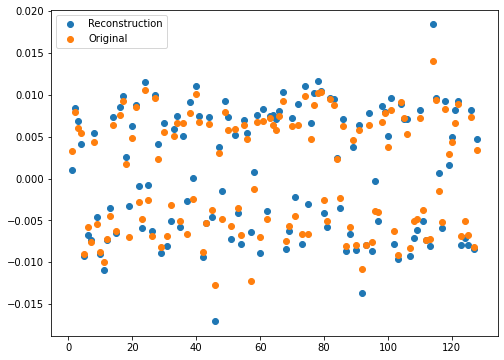

In [49]:
plt.scatter(x_axis, validate[0,:])
plt.scatter(x_axis, validate_decoder[0,0,:])

plt.legend(['Reconstruction','Original'],loc='upper left')

# Verify w/ Lv1...

In [50]:
temp4 = np.zeros([1,Lv2_latent_dim])
temp4[0,:] = Lv2_latent[0,:]

Lv1_latent_decoded = Decoder(temp4)

In [51]:
Lv2_latent.shape

(10, 64)

In [52]:
Lv1_latent_decoded.shape

TensorShape([1, 800, 128])

In [53]:
filename2='test_constrained_ae/decoder_%dbatchnorm.h5' % (epoch_1)
Decoder_Lv1 = load_model(filename2)
Decoder_Lv1.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1830400)           236121600 
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1830400)           0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 128)        0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 256)        131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 256)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14300, 256)        0   

In [54]:
temp5 = np.zeros([1, Lv1_latent_dim])
temp6 = np.zeros([num_time, num_node, num_var])

for i in range(num_time):
    temp5[0,:] = Lv1_latent_decoded[0,i,:]
    Lv1_decoded = Decoder_Lv1(temp5)
    temp6[i,:,:]=Lv1_decoded[0,:,:]
    


In [55]:
Lv1_decoded.shape

TensorShape([1, 14300, 1])

In [56]:
temp6.shape

(800, 14300, 1)

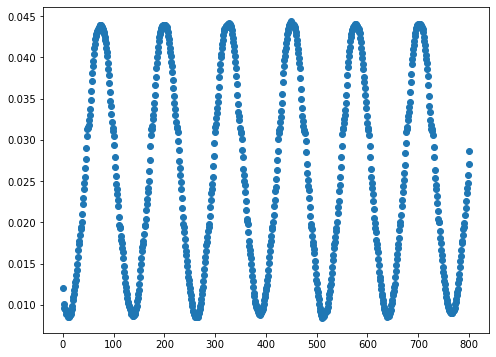

In [57]:
x_axis11 = np.linspace(1,num_time, num_time)

plt.scatter(x_axis11, temp6[:,0,0])

# Parametric interpolation in the latent space

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.


In [58]:
Lv2_latent.shape

(10, 64)

In [59]:
interp_latent = (Lv2_latent[interp1,:]+Lv2_latent[interp2,:])/2 #parameteric interpolation
interp_latent = interp_latent.reshape(1, -1)

interp_latent.shape

(1, 64)

In [60]:
interp_Lv1_latent = Decoder(interp_latent, training=False)

interp_Lv1_latent.shape

TensorShape([1, 800, 128])

In [61]:
# Unscale

In [62]:
interp_Lv1_latent = (interp_Lv1_latent*AT)+mean

In [63]:
print(interp_Lv1_latent[0,0,0], f[0,0,0])

tf.Tensor(0.16548239, shape=(), dtype=float32) 0.000995875301932174


In [64]:
filename4 = 'interpolated_latentcode_batchnorm'

np.savetxt(filename4, interp_Lv1_latent[0,:,:], fmt = '%f')

In [65]:
pause;

NameError: name 'pause' is not defined